# LCA and design optimization of an electric drone

````{card}
Author
^^^
Félix POLLET <br>
[felix.pollet@isae-supaero.fr](felix.pollet@isae-supaero.fr)
````

The aim of this notebook is to study the LCA of transporting packages using a battery-powered drone, and to redesign the drone to reduce the environmental impacts. In particular, we'll be putting ourselves in the role of a drone designer seeking to improve the environmental impact of its products.

## 1. Goal and scope

```{exercise} Goal & scope for drone package transportation
:label: goal

Propose a definition for the goal and scope.
```

```{solution} goal
:class: dropdown

**Goal**<br>
The objective of this study is to evaluate the environmental impacts associated with transporting a package using a battery-powered drone. For this purpose, a reference drone will be assessed, and design alternatives will be evaluated for comparison with the reference. In particular, the sensitivity to the size of the drone and the battery technology will be assessed to explore opportunities for reducing the impacts.

**Product & Functional Unit**<br>
The operation consists of delivering a 1 kg package from point A to point B at a distance of 7.5 kilometres and a speed of 18 km/h. For this purpose, the drone is required to have a flight endurance of at least 25 minutes. It is assumed that this mission will be carried out 5 times a day (only during working days) for 2 years, i.e. 2500 trips. For better understanding, the functional unit will be reported per unit of package delivered rather than the total number of packages transported.

**Boundaries**<br>
The study encompasses the production of the drone components and their transportation to the final assembly site. Also included is the electricity required to power the drone during the use phase. The components are treated as wastes at the end of their life, such that no recycling is considered. The processes and facilities required for the final assembly of the drone are excluded from the study, as well as the ground infrastructures and the ancillary systems (e.g., battery chargers) that support the flight operation.

**Methodological choices**<br>
The impact assessment relies on the EU Product Environmental Footprint (PEF) method v3.1 which covers 16 environmental impacts. Most of the data for the inventory (LCI) relies on the EcoInvent database.
```


### Python setup

The following lines enable to setup the LCA project and import the necessary ressources. Run them without any change.

In [1]:
# Import libraries
import brightway2 as bw
import os 
import lca_algebraic as agb
from sympy import init_printing
import matplotlib.pyplot as plt
from supporting_data.helpers import *
NETWORK_PATH = './supporting_data/lca_activities.html'

# Logging settings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Pretty print for Sympy
init_printing()

# Set current project
bw.projects.set_current('LCA_course')
agb.resetParams()

# Import database for aircraft LCA model
USER_DB = 'Foreground Drone'
agb.import_db("supporting_data/db_drone.bw2")

Writing activities to SQLite3 database:
0% [#######] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/22/2024 15:59:32
  Finished: 04/22/2024 15:59:32
  Total time elapsed: 00:00:00
  CPU %: 2.60
  Memory %: 1.17


[ParamRegistry] Param mass_batteries was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param mass_motors was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param mass_propellers was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param mass_structure was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param mission_energy was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param n_cycles_battery was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param n_missions was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param battery_type was already defined in 'Foreground Drone' : overriding.
[ParamRegistry] Param elec_mix was already defined in 'Foreground Drone' : overriding.


Brightway2 SQLiteBackend: Foreground Drone

## 2. Introduction to the *Parametric* Life Cycle Assessment

Let's start by importing the activity that aggregates all the necessary inputs and outputs for transporting a package with a drone. The construction of this activity is beyond the scope of this course, but interested readers can have a look at [this notebook](supporting_data/drone_lca_model.ipynb) to see how it has been implemented.

In [2]:
# Activity representing the lifecycle related to the transportation of a package with a drone
drone_delivery = agb.findActivity(
    name="package transport, drone",
    db_name=USER_DB
)

You can display what is known as a *process tree*, which is a hierarchical representation of the activities and flows required to fulfil the functional unit being assessed. The rectangles represent individual activities. The grey ones are aggregated activities provided directly by the EcoInvent database. The arrows illustrate the flows between each activity, i.e. the amount of a given activity required to complete the parent activity (at the head of the arrow).

In [3]:
# Display process tree
graph_activities(USER_DB, drone_delivery, NETWORK_PATH)
from IPython.display import IFrame
IFrame(src='supporting_data/lca_activities.html', width="100%", height="500px")

lca_activities.html


:::{note}
The process tree could be further developed for each EcoInvent activity. However, as a drone designer, we have no direct influence on how these activities are achieved. For example, the industrial processes for manufacturing an electric motor are beyond our control. 

Therefore, it is common in LCA studies to distinguish the **background** activities, which are considered fixed, from the **foreground** activities, which can be controlled by the organisation. 

Here, the design of the drone, which includes the size of the components and the energy consumption of the vehicle, is under the influence of the designer. Only these foreground activities can be manipulated to improve the environmental performance of the product.
:::

:::{hint} Parameterized LCA
As shown in the process tree, the amount of activities (i.e. the flows) required to fulfil the functional unit can be described by **parameters** rather than by fixed values. It is therefore possible to evaluate a range of alternative scenarios (typically, different drones) by varying the values of the parameters.

A description of the LCA parameters used in this study is provided below. Take some time to understand each parameter and how they relate to the design of the drone or to a broader context of operation.
:::

In [4]:
# Print description of parameters
print_parameters(USER_DB)

,name,description,values,default,unit
0,mass_motors,mass of motors,float,0.17,kg
1,mass_propellers,mass of propellers,float,0.06,kg
2,elec_mix,switch on electricty mix,"[eu, fr, us]",eu,
3,mass_batteries,mass of batteries,float,0.59,kg
4,n_cycles_battery,number of cycles for the battery,float,500,
5,n_missions,number of missions over drone lifetime,float,"2,500",
6,mission_energy,energy consumption for a single mission,float,0.11,kWh
7,mass_structure,mass of structure,float,0.27,kg
8,battery_type,battery technology,"[lfp, nmc]",nmc,


Before going any further, we define the LCIA methods that will be employed in the study:

In [5]:
# List of impact methods to consider
impact_methods = agb.findMethods("", mainCat="EF v3.1")
impact_methods = [impact_methods[i] for i in [0, 1, 5, 8, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 23, 24]]

# Display the selected methods
df = pd.DataFrame(impact_methods, columns=['Methods package', 'Impact category', 'Indicator (unit of measure)'])
with pd.option_context('display.max_colwidth', None):
    display(df)

,Methods package,Impact category,Indicator (unit of measure)
0,EF v3.1,acidification,accumulated exceedance (AE)
1,EF v3.1,climate change,global warming potential (GWP100)
2,EF v3.1,ecotoxicity: freshwater,comparative toxic unit for ecosystems (CTUe)
3,EF v3.1,energy resources: non-renewable,abiotic depletion potential (ADP): fossil fuels
4,EF v3.1,eutrophication: freshwater,fraction of nutrients reaching freshwater end compartment (P)
5,EF v3.1,eutrophication: marine,fraction of nutrients reaching marine end compartment (N)
6,EF v3.1,eutrophication: terrestrial,accumulated exceedance (AE)
7,EF v3.1,human toxicity: carcinogenic,comparative toxic unit for human (CTUh)
8,EF v3.1,human toxicity: non-carcinogenic,comparative toxic unit for human (CTUh)
9,EF v3.1,ionising radiation: human health,human exposure efficiency relative to u235


## 3. LCA of the reference drone

In this section, the LCA of a reference drone that meets the performance requirements defined in the functional unit is carried out. The technical specifications of this drone are provided below.

| Drone specificiations      |        |
|-----------------------|--------|
| Number of propellers / arms     | 4      |
| Total mass (including a 1 kg package)           | 2.1 kg     |
| Mass of propellers    | 0.06 kg      |
| Mass of motors     | 0.17 kg      |
| Mass of battery   | 0.59 kg       |
| Battery technology     | Li-Ion battery with NMC chemistry (Nickel-Manganese-Cobalt). Lifetime expectancy = 500 charge-discharge cycles.  |
| Mass of structures | 0.27  kg     |
| Energy consumption per ride (25-minutes mission with a 1 kg package) | 110 Wh    |

```{exercise} Impact assessment of the reference drone
:label: parameters

Fill the parameter values and run the impact assessment. 

What are the main contributors to the environmental impacts?
```

In [6]:
# Value of parameters for the reference drone - TO COMPLETE
parameters = {
    "elec_mix": "eu",  # "fr", "eu" or "us"
    "n_missions": 2500,
    "mission_energy": 0.110,    # [kWh]
    "mass_batteries": 0.59,     # [kg]
    "battery_type": "nmc",      # "nmc" or "lfp"
    "n_cycles_battery": 500,
    "mass_propellers": 0.06,    # [kg]
    "mass_motors": 0.17,        # [kg]
    "mass_structure": 0.27,     # [kg]         
}

In [7]:
# Compute impacts
agb.compute_impacts(
    
    # Activity to assess
    drone_delivery, 
    
    # list of impacts to consider
    impact_methods, 

    # values of parameters to apply for calculation
    **parameters,

    # Get contributions by lifecycle phase
    axis="phase",
)

[INFO] Db changed recently, clearing cache expr
[INFO] Db changed recently, clearing cache lcia


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,acidification - accumulated exceedance (AE)[mol H+-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq],human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq],particulate matter formation - impact on human health[disease incidence],photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,
_other_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
drone_production,0.000358063,0.0304388,0.344654,0.419954,1.94158e-05,4.0819e-05,0.000398906,1.5087e-10,1.76785e-09,0.00407846,0.138486,2.66251e-06,4.74017e-10,2.59765e-09,0.000124142,0.0478428
use_phase,0.000211763,0.0362188,0.149682,0.83813,3.35307e-05,3.32315e-05,0.000297865,8.55495e-11,6.34024e-10,0.0231514,0.186419,4.85952e-07,6.63678e-10,7.55448e-10,9.80685e-05,0.0228049
*sum*,0.000569826,0.0666577,0.494336,1.25808,5.29465e-05,7.40505e-05,0.000696771,2.3642e-10,2.40187e-09,0.0272298,0.324905,3.14847e-06,1.13769e-09,3.3531e-09,0.000222211,0.0706477


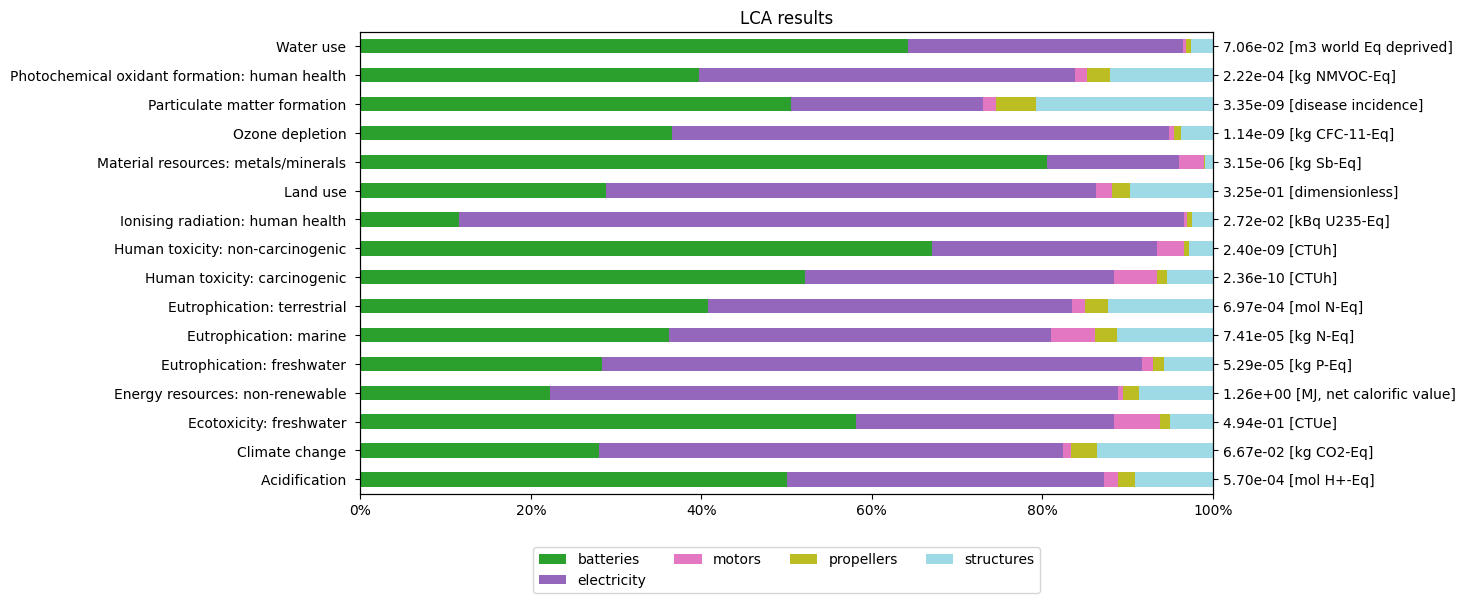

In [8]:
# Detailed contributions
results_lca = agb.compute_impacts(
    drone_delivery, 
    impact_methods, 
    **parameters,
    axis="subphase",
)
ax = plot_lca(results_lca, relative=True)
ax.set_title('LCA results');

```{exercise} Sensitivity assessment
:label: parameters

Are the results sensitive to the electricity mix (France, Europe or US)? To the estimated battery lifetime?
```

:::{caution}
Be careful when modifying the value of some LCA parameters. Although some of them can be changed independently of the others (e.g. the electricity mix is independent of the drone design), others are highly correlated. 

For example, a drone with a heavier battery will use more energy to power the flight, so the `mass_batteries` and `mission_energy` parameters cannot be changed independently. The value of these parameters should only be set after a design analysis to ensure consistent results. This is explained in bit more detail in the next section.
:::


## 4. Exploration of alternative drone candidates: optimizing the design to reduce environmental impact

### 4.a) A bit of context
Designing a product, such as a drone, involves making many decisions. For instance, propellers come in a range of sizes and materials. Similarly, batteries are available with different chemistries and capacities. Of course, some choices can be discarded as they won't satisfy the requirements. For example, a small battery won't keep a drone in the air for long. Still, there exist a quasi-infinite number of alternative solutions. With so many options, how do we choose the best design? This is where design optimization comes into play. 

Design optimization aims to identify the most optimal design given a set of requirements (e.g., the drone should be able to lift a one kilogram package during 25 minutes). However, it is crucial to define what constitutes "optimal". Usually, the best design is defined as a balance between different factors, with economic considerations playing a pivotal role. For example, we might want a drone that's cheap to manufacture and/or to operate.

In this section, we'll explore different drone designs, each optimized based on different criteria. Specifically, we'll consider:

- The lightest drone that still meets the mission requirements

- The one that consumes the least energy for performing the mission (is it the lightest?)

- The one with the minimal environmental impact, such as mitigating climate change.

:::{hint} Design optimization in a nutshell
Design optimization is like finding the perfect recipe for a dish. You have a list of ingredients (design options) and you want to combine them in the best way to create the most delicious meal (optimal design).

In engineering, it's similar. You have various design choices, such as materials, dimensions, and configurations. Design optimization helps you figure out the ideal combination of these choices to meet your goals, whether it's maximizing performance, minimizing cost, or reducing environmental impact.

Using physical models and numerical algorithms, design optimization searches through all the possible combinations to find the one that best meets your criteria.
:::

:::{hint} Mathematical formulation
Mathematically, a design optimization problem can be expressed as follows:

```{math}
:label: mymath
\begin{align*}
&{\operatorname{minimize}}& & f(x) \\
&\operatorname{with\;respect\;to}
& &x \in X \subseteq R^n \\
&\operatorname{subject\;to}
& &h_i(x) = 0, \quad i = 1, \dots,m_1 \\ 
&&&g_j(x) \leq 0, \quad j = 1,\dots,m_2 \\
\end{align*}
```

The **design variables** $x$ represent the parameters that can be changed in the design, such as dimensions, materials, or configurations (e.g. 4, 6 or 8 propellers). Each variable has a range or set of possible values that it can take.

The **objective function** $f(x)$ represent what must be optimized, for example the total mass of the drone.

The **constraints** $g(x)$ and $h(x)$ reflect some physical limitations (e.g. the propellers should not overlap) or performance requirements (e.g. flight endurance), among others.
:::

:::{note} Design versus sizing
The definition of a design optimization problem can be divided into three main sub-problems: material/technology selection, configuration selection and finally sizing, i.e. dimensioning of the components.

In this section, only the sizing sub-problem is addressed. The drone configuration is fixed to a quadcopter, i.e. with four propellers. The material for the structure and the propellers is set to a composite fabric. Finally, a Li-ion NMC battery technology is selected. Therefore, only the following dimensions of the components will be varied during the optimization:
- Propeller diameter
  
- Motor size
  
- Battery capacity
  
- Arms length
:::


### 4.b) The calculations

Do not worry, we are not asking you to create a design optimization solver from scratch. Instead, this notebook provides you with the `sizing_optimization` function, which will perform the optimization routine for you. All you have to do is define some input values such as the performance requirements, call the `sizing_optimization` function, and voila! You have an optimal drone design on which you can then perform an impact assessment.

Let's start by importing this magic function and set up some values for the design problem:

In [9]:
# Import the functions that executes the sizing optimization
from supporting_data.drone_sizing import sizing_optimization

### Performance requirements for the mission
performances = [
    1.0,  # [kg] mass of the package to lift
    25.0, # [min] flight duration
]

### Reference technology for the battery
technology = [
    200.0,   # [Wh/kg] energy density of the battery (Li-Ion NMC technology)
]

### Other specific LCA parameters
lca_param = {
    "battery_type": "nmc",
    "n_cycles_battery": 500,
    "elec_mix": "eu",
    "n_missions": 2500,
    "lca_model": drone_delivery
}

Now, we run the sizing optimization with a mass minimization objective, i.e. we want to obtain the lightest drone possible:

In [10]:
# Set objective to minimize
objective = 'mass'

# Run optimization
drone_parameters, lca_parameters = sizing_optimization(performances, technology, lca_param, objective)  # this optimizes the design according to the specifications

# Print parameters of the optimal drone
drone_parameters

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5721649032871894
            Iterations: 23
            Function evaluations: 120
            Gradient evaluations: 23


,0
Drone mass [kg],1.90106
Propellers diameter [m],0.336911
Motors nominal torque [N.m],0.1
Battery energy [Wh],64.03
Arms length [m],0.238232


This is our lightest drone that is able to complete the package delivery mission. Let's calculate its environmental impacts:

In [11]:
# Compute LCA corresponding to optimal design
results_lca_mass = agb.compute_impacts(
    drone_delivery, 
    impact_methods, 
    **lca_parameters.to_dict()['value'],
    axis="phase",
)
results_lca_mass

,acidification - accumulated exceedance (AE)[mol H+-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq],human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq],particulate matter formation - impact on human health[disease incidence],photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,
_other_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
drone_production,0.000245091,0.0250436,0.219813,0.330084,1.35707e-05,3.11976e-05,0.000298405,9.78582e-11,1.04867e-09,0.00286386,0.106138,1.50443e-06,2.98381e-10,2.06465e-09,9.29082e-05,0.027733
use_phase,9.86122e-05,0.0168661,0.0697028,0.390294,1.56143e-05,1.5475e-05,0.000138708,3.98381e-11,2.95248e-10,0.010781,0.0868104,2.26295e-07,3.09057e-10,3.51791e-10,4.56678e-05,0.0106196
*sum*,0.000343704,0.0419097,0.289516,0.720378,2.91851e-05,4.66726e-05,0.000437112,1.37696e-10,1.34392e-09,0.0136448,0.192948,1.73072e-06,6.07438e-10,2.41644e-09,0.000138576,0.0383527


```{exercise} Comparative study
:label: comparative

Re-run the optimization by changing the objective. The objective can be one of the following:

- `'energy'`: to find the most energy-efficient design

- `('EF v3.1', 'climate change', 'global warming potential (GWP100)')` to minimize the climate change

- Or any other environmental impact category (refer to the LCIA methods table at the beginning of this notebook)

Then, compare the different drone designs and their LCA results. Identify the burden shifts (if any) from one life cycle stage to another, and/or from one impact category to another.

```

In [12]:
# Set objective to minimize
objective = 'energy'

# Run optimization
drone_parameters, lca_parameters = sizing_optimization(performances, technology, lca_param, objective)  # this optimizes the design according to the specifications

# Compute LCA of corresponding design
results_lca_energy = agb.compute_impacts(
    drone_delivery, 
    impact_methods, 
    **lca_parameters.to_dict()['value'],
    axis="phase",
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0307854317416982
            Iterations: 18
            Function evaluations: 94
            Gradient evaluations: 18


In [13]:
drone_parameters

,0
Drone mass [kg],2.18219
Propellers diameter [m],0.444028
Motors nominal torque [N.m],0.151284
Battery energy [Wh],59.7495
Arms length [m],0.313975


In [14]:
# Plot comparison of LCA results
plot_lca_comparison([results_lca_mass, results_lca_energy, results_lca_climate])

NameError: name 'results_lca_climate' is not defined

### 4.c) Multi-objective optimization

In most situations, it is not possible to find a design that minimizes all environmental impacts simultaneously, as the goals might be conflicting. It is therefore necessary to make a trade-off between the various objectives to allow choosing one preferable solution among the alternatives. This is the purpose of **multi-objective optimization**.

One way to achieve multi-objective optimization is to build an aggreagated objective which reflects the relative importance of the different objectives. This is achieved by assigning weights $\omega_i$ to each objective $f_i$:
```{math}
\begin{align}
f = \sum_i^n \omega_i f_i
\end{align}
```

Properly setting and interpreting weights is crucial to ensure that the resulting solution reflects the intended trade-offs and preferences. In this case study, the weights are set up to reflect the [normalization and weighting factors of the EF methods](https://eplca.jrc.ec.europa.eu/permalink/EF3_1/Normalisation_Weighting_Factors_EF_3.1.xlsx).

```{exercise} Multi-objective optimization
:label: multiobj

Run the multi-objective optimization and compare the results with those obtained previously.  Given the potentially low fidelity of the physical models used in the design optimization, be critical of the accuracy of the results.
```

In [15]:
# Multi-objective
objective = {
    ('EF v3.1', 'climate change', 'global warming potential (GWP100)'): 0.2106/7.55E+03,  # divide by EF normalisation factor and multiply by EF weighting factor
    ('EF v3.1', 'acidification', 'accumulated exceedance (AE)'): 0.0620/5.56E+01,
    ('EF v3.1', 'ecotoxicity: freshwater', 'comparative toxic unit for ecosystems (CTUe)'): 0.0192/5.67E+04,
    ('EF v3.1', 'energy resources: non-renewable', 'abiotic depletion potential (ADP): fossil fuels'): 0.0832/6.50E+04,
    ('EF v3.1', 'eutrophication: freshwater', 'fraction of nutrients reaching freshwater end compartment (P)'): 0.0280/1.61,
    ('EF v3.1', 'eutrophication: marine', 'fraction of nutrients reaching marine end compartment (N)'): 0.0296/1.95E+01,
    ('EF v3.1', 'eutrophication: terrestrial', 'accumulated exceedance (AE)'): 0.0371/1.77E+02,
    ('EF v3.1', 'human toxicity: carcinogenic', 'comparative toxic unit for human (CTUh)'): 0.0213/1.73E-05,
    ('EF v3.1', 'human toxicity: non-carcinogenic', 'comparative toxic unit for human (CTUh)'): 0.0184/1.29E-04,
    ('EF v3.1', 'ionising radiation: human health', 'human exposure efficiency relative to u235'): 0.0501/4.22E+03,
    ('EF v3.1', 'land use', 'soil quality index'): 0.0794/8.19E+05,
    ('EF v3.1', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)'): 0.0755/6.36E-02,
    ('EF v3.1', 'ozone depletion', 'ozone depletion potential (ODP)'): 0.0631/5.23E-02,
    ('EF v3.1', 'particulate matter formation', 'impact on human health'): 0.0896/5.95E-04,
    ('EF v3.1', 'photochemical oxidant formation: human health', 'tropospheric ozone concentration increase'): 0.0478/4.09E+01,
    ('EF v3.1', 'water use', 'user deprivation potential (deprivation-weighted water consumption)'): 0.0851/1.15E+04,
}

# Run design optimization
drone_parameters, lca_parameters = sizing_optimization(performances, technology, lca_param, objective)  # this optimizes the design according to the specifications

# Compute LCA
results_lca_multi = agb.compute_impacts(
    drone_delivery, 
    impact_methods, 
    **lca_parameters.to_dict()['value'],
    axis="phase",
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.358083648491792
            Iterations: 17
            Function evaluations: 88
            Gradient evaluations: 17


In [16]:
drone_parameters

,0
Drone mass [kg],1.9275
Propellers diameter [m],0.34986
Motors nominal torque [N.m],0.105288
Battery energy [Wh],62.951
Arms length [m],0.247389


<Axes: title={'center': 'LCA results (relative comparison)'}>

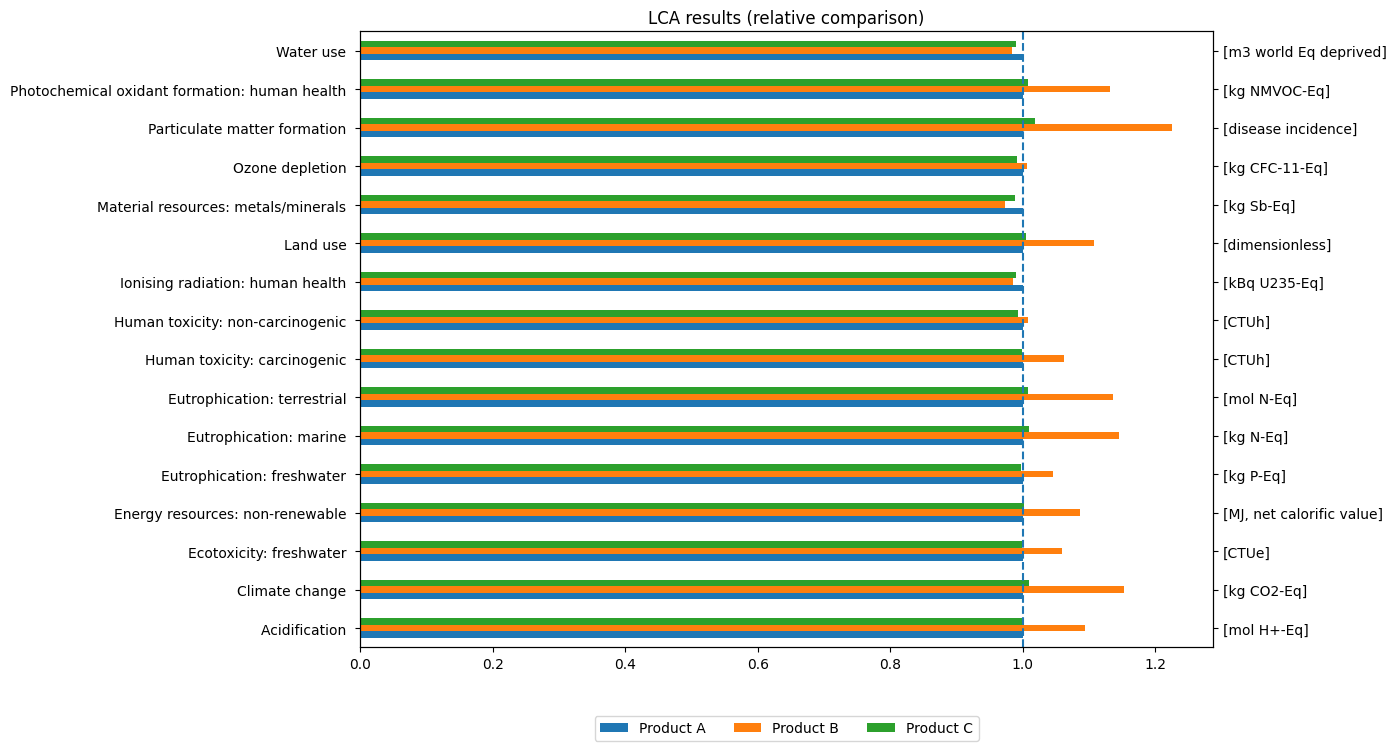

In [17]:
# Plot comparison of LCA results
plot_lca_comparison([results_lca_mass, results_lca_energy, results_lca_multi])

## 5. Comparison of battery technologies

There are several battery technologies or chemistries that can be used in air mobility applications. The following table shows the specifications of two types of batteries.

| Battery technology | Energy density | Average lifetime (number of charge-discharge cycles) |
|------------------|--------------------|------------------|
| Li-Ion NMC (Nickel-Manganese-Cobalt cathode)       | 200 Wh/kg          | 500              |
| Li-Ion LFP (Lithium Ferro Phosphate cathode)     | 130 Wh/kg          | 2000             |


```{exercise} Light vs durable: who wins?
:label: battery

The table above shows that the NMC battery is lighter than its counterpart for the same amount of stored energy. As a result, a drone design using this type of battery will be lighter and consume less energy during flight. However, NMC batteries are less durable than LFPs and will need to be replaced (so produced) more often.

Is it better to use an NMC or an LFP battery to design a drone with minimal environmental impacts? Run the following cells and analyse the results. Identify the burden shifts from one life cycle stage to another and from one impact category to another.
```


In [18]:
### Performance requirements for the mission
performances = [
    1.0,  # [kg] mass of payload (package) to lift
    25.0, # [min] flight duration
]

### Reference technology for the battery
technology = [
    130.0,   # [Wh/kg] rapport énergie/masse de la batterie
]

### Other specific LCA parameters
lca_param = {
    "elec_mix": "eu",
    "n_missions": 2500,
    "n_cycles_battery": 2000,
    "battery_type": "lfp",
    "lca_model": drone_delivery
}

In [19]:
# Run optimization
drone_parameters, lca_parameters = sizing_optimization(performances, technology, lca_param, objective)  # this optimizes the design according to the specifications

# Compute LCA corresponding to optimal design
results_lca_multi_lfp = agb.compute_impacts(
    drone_delivery, 
    impact_methods, 
    **lca_parameters.to_dict()['value'],
    axis="phase",
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.217123326413355
            Iterations: 15
            Function evaluations: 78
            Gradient evaluations: 15


<Axes: title={'center': 'LCA results (relative comparison)'}>

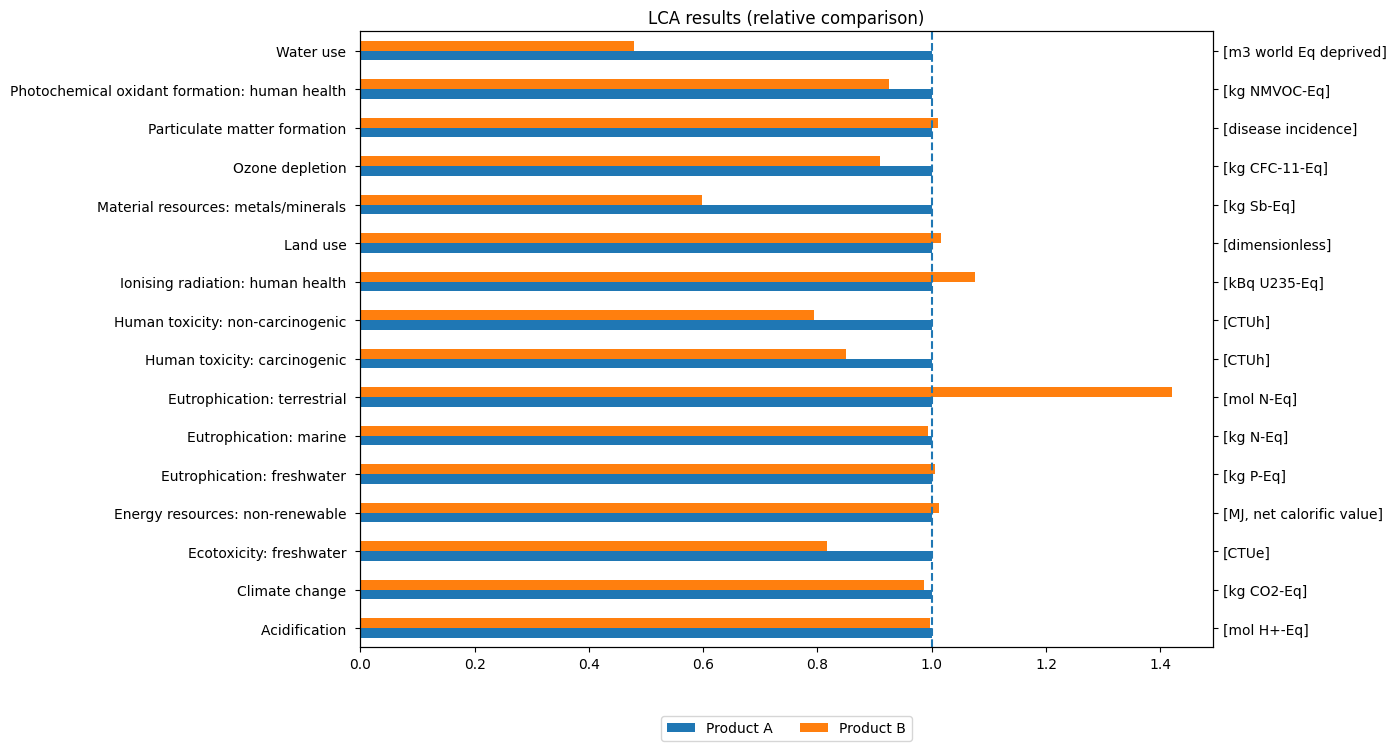

In [20]:
# Plot comparison of LCA results
plot_lca_comparison([results_lca_multi, results_lca_multi_lfp])

In [21]:
results_lca_multi

,acidification - accumulated exceedance (AE)[mol H+-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq],human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq],particulate matter formation - impact on human health[disease incidence],photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,
_other_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
drone_production,0.000247638,0.0257342,0.220594,0.337856,1.37423e-05,3.18789e-05,0.000304104,9.83867e-11,1.04324e-09,0.00290097,0.108427,1.48759e-06,2.98753e-10,2.11537e-09,9.46861e-05,0.0274977
use_phase,9.69504e-05,0.0165819,0.0685282,0.383717,1.53512e-05,1.52142e-05,0.00013637,3.91667e-11,2.90272e-10,0.0105993,0.0853475,2.22481e-07,3.03848e-10,3.45863e-10,4.48982e-05,0.0104407
*sum*,0.000344589,0.0423161,0.289122,0.721573,2.90935e-05,4.70932e-05,0.000440474,1.37553e-10,1.33352e-09,0.0135002,0.193774,1.71008e-06,6.02601e-10,2.46123e-09,0.000139584,0.0379384


In [22]:
results_lca_multi_lfp

,acidification - accumulated exceedance (AE)[mol H+-Eq],climate change - global warming potential (GWP100)[kg CO2-Eq],ecotoxicity: freshwater - comparative toxic unit for ecosystems (CTUe)[CTUe],"energy resources: non-renewable - abiotic depletion potential (ADP): fossil fuels[MJ, net calorific value]",eutrophication: freshwater - fraction of nutrients reaching freshwater end compartment (P)[kg P-Eq],eutrophication: marine - fraction of nutrients reaching marine end compartment (N)[kg N-Eq],eutrophication: terrestrial - accumulated exceedance (AE)[mol N-Eq],human toxicity: carcinogenic - comparative toxic unit for human (CTUh)[CTUh],human toxicity: non-carcinogenic - comparative toxic unit for human (CTUh)[CTUh],ionising radiation: human health - human exposure efficiency relative to u235[kBq U235-Eq],land use - soil quality index[dimensionless],material resources: metals/minerals - abiotic depletion potential (ADP): elements (ultimate reserves)[kg Sb-Eq],ozone depletion - ozone depletion potential (ODP)[kg CFC-11-Eq],particulate matter formation - impact on human health[disease incidence],photochemical oxidant formation: human health - tropospheric ozone concentration increase[kg NMVOC-Eq],water use - user deprivation potential (deprivation-weighted water consumption)[m3 world Eq deprived]
phase,,,,,,,,,,,,,,,,
_other_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
drone_production,0.000225473,0.0215646,0.1528,0.263577,1.05637e-05,2.82228e-05,0.000459772,6.91694e-11,7.04162e-10,0.00160964,0.0930588,7.50794e-07,1.77823e-10,2.06502e-09,7.43347e-05,0.00542264
use_phase,0.000118103,0.0201997,0.0834794,0.467435,1.87005e-05,1.85336e-05,0.000166123,4.7712e-11,3.53603e-10,0.0129118,0.103968,2.71021e-07,3.70141e-10,4.21322e-10,5.4694e-05,0.0127186
*sum*,0.000343576,0.0417642,0.23628,0.731013,2.92642e-05,4.67564e-05,0.000625894,1.16881e-10,1.05776e-09,0.0145214,0.197027,1.02182e-06,5.47964e-10,2.48634e-09,0.000129029,0.0181412
